<a href="https://colab.research.google.com/github/akhilb5/Centralized-repository-shipping_calculations/blob/main/IntroductionToNeuralNetworksPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks

Author: Julie Butler, University of Mount Union

Data Science for Nuclear Physicsts Workshop

Division of Nuclear Physics Conference

October 17 - 20, 2025; Chicago, IL

## Introduction to the Data Set

The data set we will investigate in this notebook contains the following data for every measurable [isotope](https://en.wikipedia.org/wiki/Isotope): number of neutrons, number of protons, number of nucleons, [binding energy](https://en.wikipedia.org/wiki/Binding_energy), the uncertainty of binding energy measurement, atomic mass, and uncertainty on mass measurement. This notebook section will help you better understand this data set and why nuclear scientists may want to study it. The data used in this notebook was taken from the [AME2016 atomic mass evaluation](http://nuclearmasses.org/resources_folder/Wang_2017_Chinese_Phys_C_41_030003.pdf).

### Isotopes and Nucleons

The nucleus of an atom contains two types of particles: positively charged particles called **protons** and neutral particles called **neutrons**. The total number of protons in the nucleus is Z, and the total number of neutrons is N. Protons and neutrons are both types of **nucleons**, so the total number of nucleons in the nucleus is A = Z + N.

The number of protons in the nucleus determines what **element** it is. For example, all nuclei with 12 protons are carbon nuclei, all nuclei with 1 proton are hydrogen, and all nuclei with 20 protons are calcium. However, the number of neutrons in a nucleus does not define an element. So there are carbon atoms with 11 neutrons, 12 neutrons, 13 neutrons, and so on. Nuclei that have the same number of protons but different numbers of neutrons are referred to as **isotopes** of each other.

### Atomic Mass

An atom's **atomic mass** is the atom's total mass (i.e., the nucleus and the protons). Note that it is not the same as the sum of the masses of the particles that make up the atom. This will be explored in the next section.

### Binding Energy

The mass of an atomic nucleus will be less than the total mass of its constituent particles. This difference in mass is called the binding energy, as it is the energy required to hold the atom together. Remember that mass and energy are related by the famous equation from Einstein: $E = mc^2$.

To calculate the theoretical binding energies using Einstein's equation, we can define the binding energy as:

$$BE = Mc^2 - mc^2,$$

where M is the total mass of all of the particles in the atom, m is the actual atomic mass of the atom, and c is the speed of light in a vacuum. We can define M as:

$$M = Z(m_p + m_e) + Nm_n,$$

where m$_p$ is the mass of a proton, m$_e$ is the mass of an electron, and m$_n$ is the mass of a neutron. So, we can rewrite the binding energy as:

$$BE = ((m_p + m_e)Z + m_nN - m)c^2.$$

Next, we can define the atomic mass of hydrogen as one proton plus one electron:
$$m_h = m_p + m_e,$$

which means we can rewrite the binding energy as:

$$BE = (m_hZ + m_nN - m)c^2,$$

where $m_h$ = 1.007 MeV, $m_n$ = 1.008 MeV and $c^2$ = 931.49 MeV/u.

The binding energies in the data set are experimental binding energies. Later in this notebook, we will determine how well the experimental binding energies correspond to the theoretical ones we defined in this section.

### Uncertainties

The atomic masses and binding energies in this data set were collected through experiments. Any data collected through experimentation has uncertainty in it. Though these are usually relatively small, they are also presented in this data set.

In [ ]:
# Import the pandas library to import the data file as a Pandas dataframe for easy
# manipulation and viewing
import pandas as pd

# Import the data from a TSV file as a Pandas dataframe
# Note this file is imported directly from the Github page via the URL
nuclear_data = pd.read_csv("https://raw.githubusercontent.com/butler-julie/DataExplorationAndVisualization/main/nuclear_data.tsv",
                           sep="\t")

# Print the DataFrame
# Note that the last time of a code cell will be printed even without a print statement
nuclear_data

# The data set contains many "#" symbols which indicate that the number was the result of
# an extrapolation and not an experimental measurement. Let's remove these by first forcing
# the relavent columns of data to be numeric (which forces any entry with a # to NaN) and then
# we can drop any row that contains a NaN.
nuclear_data['BE'] = pd.to_numeric(nuclear_data['BE'], errors='coerce')
nuclear_data['BEd'] = pd.to_numeric(nuclear_data['BEd'], errors='coerce')
nuclear_data['MASS'] = pd.to_numeric(nuclear_data['MASS'], errors='coerce')
nuclear_data['MASSd'] = pd.to_numeric(nuclear_data['MASSd'], errors='coerce')

nuclear_data = nuclear_data.dropna()


# Convert the binding energy per nucleon and its uncertainity from keV to MeV and convert
# the mass and its uncertainty from micro-atomic units to atomic units.
nuclear_data["BE"] /= 1e3
nuclear_data["BEd"] /= 1e3

nuclear_data["MASS"] *= 1e-6
nuclear_data["MASSd"] *= 1e-6

Text(0, 0.5, 'Nuclear Mass (u)')

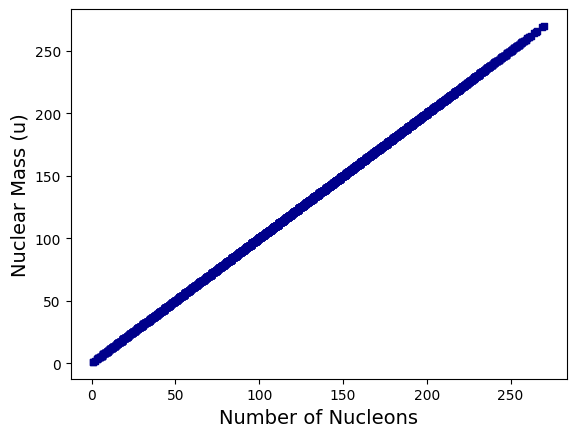

In [ ]:
# Import matplotlib for creating plots.
import matplotlib.pyplot as plt

# Create a scatter plot of number of nucleons against the nuclear mass. This graph is
# relatively linear.
plt.scatter(nuclear_data["A"], nuclear_data["MASS"], s=15,
            color="darkblue",marker="s")
plt.xlabel("Number of Nucleons",fontsize=14)
plt.ylabel("Nuclear Mass (u)",fontsize=14)

Text(0, 0.5, 'Binding Energy per Nucleon (MeV)')

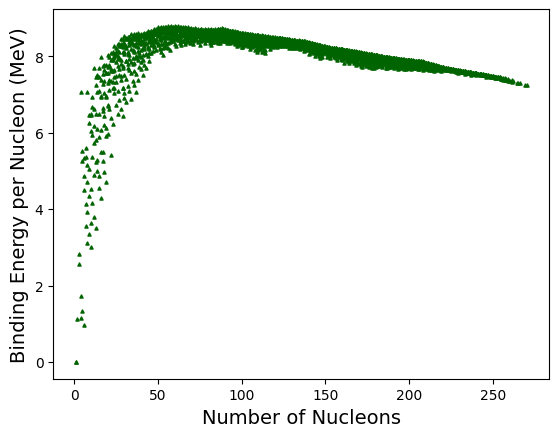

In [ ]:
# Now create a scatter plot of number of nucleons versus binding energy per nucleon. This
# graphs is much more interesting so we will try to predict binding energy per nucleon with
# a neural network.
plt.scatter(nuclear_data["A"], nuclear_data["BE"], s=5,
            color="darkgreen",marker="^")
plt.xlabel("Number of Nucleons",fontsize=14)
plt.ylabel("Binding Energy per Nucleon (MeV)",fontsize=14)

In [ ]:
# Define the X data, or the features, which will be the inputs of the neural network.
# These will be the number of protons and the number of neutrons
# We also define the y data to be the binding energy per nucleon, which will be the output
# of our neural network once it is trained.
X = nuclear_data[["Z","N"]]
y = nuclear_data["BE"]

In [ ]:
# Import the standard scaler from the scikit-learn library. This will scale the features so
# that all columns will have a mean of zero and a standard deviation of one. This helps when
# there are columns of different scales but is always a good idea with regularized machine
# learning models.
from sklearn.preprocessing import StandardScaler

# Define the standard scaler, fit it to our features, and then transform the features
# according to the standard scaler. X is now scaled moving forward.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# When training a machine learning model a good practice is to split your data set into a
# larger data set (70% - 90%) which is used to train the machine learning model and a
# smaller data set (10% - 30%) which is used to test the performance of the trained model.
# train_test_split from scikit-learn will randomly split the data into a training set and
# a test set of specified size.
from sklearn.model_selection import train_test_split

# Split the data into a training set and test set, where the test set is 20% of the total
# data (and thus the training set is 80% of the data).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Import the PyTorch library. We will need to convert our data into a PyTorch tensor data
# type to work with a PyTorch neural network. Specifically we need to convert the data into
# a tensor containing floats. Below we convert both our training and test sets from Pandas
# DataFrames and series into PyTorch tensors.
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
# Import the neural network functionality from the PyTorch library
import torch.nn as nn

# nn.Module is the base neural network class from PyTorch. We can use the inhertance
# to extend the base class to our custom neural netwrok.
class BindingEnergyNN(nn.Module):
    """
    A neural network to predict the binding energy per nucleon of a nucleus.
    """
    def __init__(self, hidden_size):
        """
        Arguments:
            hidden_size (int): The number of neurons in the hidden layer.
        Returns:
            None
        Initialize the neural network which inherits from the nn.Module class.
        """
        # initialize functionality defined through the inheritance
        super(BindingEnergyNN, self).__init__()
        # Defeine relu as the activation function
        self.relu = nn.ReLU()
        # Define a linear (fully connected, feedforward) neural network layer for the only hidden
        # layer. Since we have two features the number of input features is two and the
        # number of neurons in the hidden layer is defined in the arguments.
        self.hidden_layer = nn.Linear(2, hidden_size)
        # Define a linear neural network layer as the output layer. The input will be the
        # number of neurons on the hidden layer and the output is 1, since we are predicting
        # one value.
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass of the neural network.
        Arguments:
            x (torch.Tensor): The input data of the neural netwrok.
        Returns:
            output (torch.Tensor): The output of the neural network.
        """
        # The hidden layer has as an input the input of the neural network (as the input
        # layer does not modify the data) and uses the hidden_layer variable defined in the
        # init function to determine the output, modified by the relu function
        hidden_layer_output = self.relu(self.hidden_layer(x))
        # The output layer has as an input the output of the hidden layer and uses the
        # output_layer variable defined in the init function to determine the output.
        # The output layer does not use an activation function so that it
        output = self.output_layer(hidden_layer_output)
        return output

In [ ]:
# Import the optimizer library from PyTorch, as we will need to use it to optimize the
# weights of the neural network
import torch.optim as optim
# This variable will control the number of neurons in the hidden layer of the neural network.
hidden_size = 10
# Define an instance of the neural network class we created with one hidden layer having
# the number of neurons specified in the above variable.
model = BindingEnergyNN(hidden_size)

# When determining the performance of a regression model, the mean-squared error (MSE) is
# commonly used as a loss function.
criterion = nn.MSELoss()

# As an optimizer to find the best weights of the neural network, Adam is commmon as it
# is more resistant against local minimums
optimizer = optim.Adam(model.parameters())

Epoch [ 20 / 100 ], Loss:  60.129
Epoch [ 40 / 100 ], Loss:  58.471
Epoch [ 60 / 100 ], Loss:  56.75
Epoch [ 80 / 100 ], Loss:  54.946
Epoch [ 100 / 100 ], Loss:  53.053


Text(0, 0.5, 'Loss')

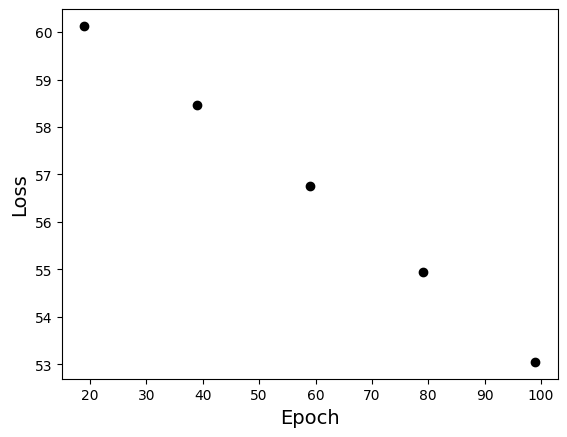

In [ ]:
# Define the number of training iterations. This needs to be large enough
# to avoid underfitting, but not so large that the network is overfit.
epochs = 100
# For each epoch...
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.reshape(-1,1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # For every 20th epoch, print the current loss and add a scatter point for
    # the loss to a plot that will show at the end of training.
    if (epoch+1) % 20 == 0:
        print("Epoch [", epoch+1, "/", epochs, "], Loss: ", round(loss.item(), 3))

        plt.scatter(epoch, loss.item(), color="black")

# Add x and y labels to the training loss plot.
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)

In [ ]:
# Now that the neural network is trained we want to make predictions
# without further changing the values of the parameters
with torch.no_grad():
    # Feed the features of the test data to the trained neural network to
    # generate a set of preditions. Calculate the MSE between these predictions
    # and the know outputs from the test data (not that you need to reshape the
    # y_test tensor for the criterion function to make its dimensions match
    # y_pred).
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test.reshape(-1,1))

# Print both the mean-squared error and the root-mean squared error.
print("Mean-Squared Error:", round(mse.item(),2))
print("Root Mean-Squared Error:", round(mse.item()**0.5,2))

Mean-Squared Error: 53.21
Root Mean-Squared Error: 7.29


In [ ]:
# Compare our average error to the average value in the binding energy data set to determine
# how the network is doing
print("Average Binding Energy:", round(nuclear_data["BE"].mean(),2))

Average Binding Energy: 8.05


In [ ]:
# As a second example, let's create a neural network to predict the binding energies which
# has two hidden layers instead of one. We will still need to inherit from the PyTorch
# Module class
class BindingEnergyNN_TwoHiddenLayers(nn.Module):
    """
    A neural network to predict the binding energy per nucleon of a nucleus.

    """
    def __init__(self, hidden_size):
        """
        Arguments:
            hidden_size (int): The number of neurons in the hidden layer.
        Returns:
            None
        Initialize a neural network with two hidden layers which inherits from the
        nn.Module class.
        """
        super(BindingEnergyNN_TwoHiddenLayers, self).__init__()
        # Relu for the activation function
        self.relu = nn.ReLU()
        # Define the first hidden layer, which will take the two inputs from the input
        # layer and have a number of neurons specified by the input variable.
        self.hidden_layer1 = nn.Linear(2, hidden_size)
        # Define the second hidden layer which will have as an input the output of the
        # first hidden layer and it will also have a number of neurons specified by the
        # input variable.
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        # The output layer will take the output of the second hidden layer and then convert
        # it to the single output.
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Arguments:
            x (torch.Tensor): The input data of the neural netwrok.
        Returns:
            output (torch.Tensor): The output of the neural network.
        Forward pass of the neural network.
        """
        # The input of the first hidden layer is the input of the neural network. The hidden
        # layer will apply the function defined above and modify it by the ReLu activation
        # function.
        hidden_layer1_output = self.relu(self.hidden_layer1(x))
        # The input of the second hidden layer is the output of the first hidden layer.
        # The hidden layer will apply the function defined above and modify it by the
        # ReLu activation function.
        hidden_layer2_output = self.relu(self.hidden_layer2(hidden_layer1_output))
        # The input of the output layer is the output of the second hidden layer.
        # The hidden layer will apply the function defined above and it does not use an
        # activation function.
        output = self.output_layer(hidden_layer2_output)
        return output

In [ ]:
# This variable will control the number of neurons in the hidden layer of the neural network.
hidden_size = 10
# Define an instance of the neural network class we created with two hidden layers having
# the number of neurons specified in the above variable.
model = BindingEnergyNN(hidden_size)

# When determining the performance of a regression model, the mean-squared error (MSE) is
# commonly used as a loss function.
criterion = nn.MSELoss()

# As an optimizer to find the best weights of the neural network, Adam is commmon as it
# is more resistant against local minimums
optimizer = optim.Adam(model.parameters())

Epoch [ 20 / 100 ], Loss:  65.457
Epoch [ 40 / 100 ], Loss:  63.753
Epoch [ 60 / 100 ], Loss:  62.042
Epoch [ 80 / 100 ], Loss:  60.273
Epoch [ 100 / 100 ], Loss:  58.403


Text(0, 0.5, 'Loss')

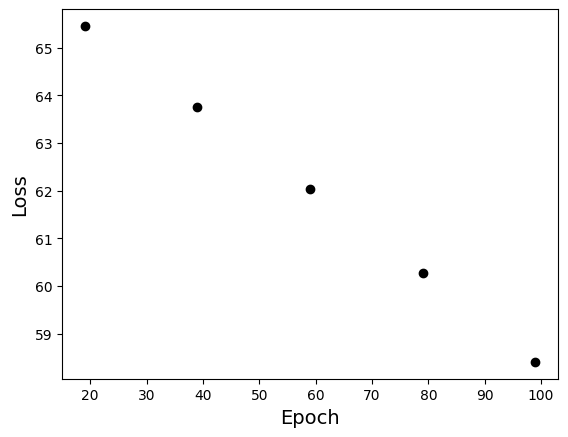

In [ ]:
# Define the number of training iterations. This needs to be large enough
# to avoid underfitting, but not so large that the network is overfit.
epochs = 100
# For each epoch...
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.reshape(-1,1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # For every 20th epoch, print the current loss and add a scatter point for
    # the loss to a plot that will show at the end of training.
    if (epoch+1) % 20 == 0:
        print("Epoch [", epoch+1, "/", epochs, "], Loss: ", round(loss.item(), 3))

        plt.scatter(epoch, loss.item(), color="black")

# Add x and y labels to the training loss plot.
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)

In [ ]:
# Now that the neural network is trained we want to make predictions
# without further changing the values of the parameters
with torch.no_grad():
    # Feed the features of the test data to the trained neural network to
    # generate a set of preditions. Calculate the MSE between these predictions
    # and the know outputs from the test data (not that you need to reshape the
    # y_test tensor for the criterion function to make its dimensions match
    # y_pred).
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test.reshape(-1,1))

# Print both the mean-squared error and the root-mean squared error.
print("Mean-Squared Error:", round(mse.item(),2))
print("Root Mean-Squared Error:", round(mse.item()**0.5,2))

Mean-Squared Error: 58.53
Root Mean-Squared Error: 7.65


In [ ]:
# In order to determine the performance of our network, let's convert
# all of our X data into a tensor, and create predictions for every
# point in X. This includes the training data and the test data.
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    preds = model(X_tensor)



Text(0, 0.5, 'Binding Energy per Nucleon (MeV)')

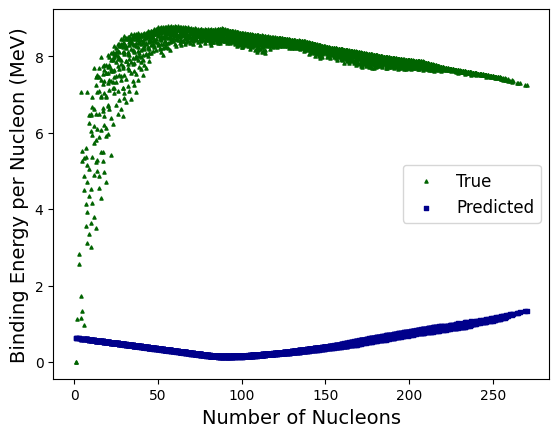

In [ ]:
# Create a plot of the true data and the output of the neural network as
# the error score can be misleading at times when determining the performance
# of a neural network.
plt.scatter(nuclear_data["A"], nuclear_data["BE"], s=5,
            color="darkgreen",marker="^", label="True")
plt.scatter(nuclear_data["A"], preds.numpy(), s=5,
            color="darkblue",marker="s",label="Predicted")
plt.legend(fontsize=12)
plt.xlabel("Number of Nucleons",fontsize=14)
plt.ylabel("Binding Energy per Nucleon (MeV)",fontsize=14)